# Notebook for extracting the Yamnet embedings and trainig a the 3 models on them


In [ ]:
pip install pydub

In [ ]:
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa
import librosa.display
import numpy as np
import pandas as pd
import os
import pickle
import pydub

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from keras.src.layers.core.masking import Masking

In [ ]:
drive_path = "/content/drive/MyDrive/Accent Detection/"

# Yamnet embedding extraction

+ To extract the Yamnet embeddings, we made use of a class we named prepare_vggish_speech_embeddings.
+ The class has 3 methods for extracting yamnet ebeddings from a single audio, extracting from a single directory and extracting from a multiple classes as seen below

+ We mainly made use of the extract_speech_embeddings_for_multiple_classes method to help us extract the Yamnet ebeddings since the data was in multiple classes as designed in the preprocessing notebook~

In [ ]:
class prepare_yamnet_speech_embeddings:
  def __init__(self):
    self.yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")
    self.df = pd.DataFrame({"embeddings": [], "label": []})



  def extract_speech_embeddings_for_single_audio(self, path, label):
    # (1) Get the signal for the audio sample and set the sample rate to 16000KHz
    signal, sr = librosa.load(path, mono = True, sr = 16000)
    signal = librosa.util.normalize(signal)

    # (2) Get the scores and embeddings using the yamnet pretrained model
    scores, embeddings, _ = self.yamnet_model(signal)

    # (3) Transform the embeddings to from tensor to numpy
    embeddings = embeddings.numpy()

    # (4) Iterate over the embeddings given by the yamnet model
    # for idx, embedding in enumerate(embeddings):

    #   # (5) Using the argmax method to find out if the yamnet model predicts the embeding as a speech or not
    #   embedding_prediction = np.argmax(scores[idx], axis = -1)

    #   # (6) If the embedding is a speech, then concatenate it with the df in the self object and label it with its specified name
    #   if embedding_prediction == 0:
    self.df = pd.concat([self.df, pd.DataFrame({"embeddings": [embeddings], "label": [label]})], ignore_index = True, axis = 0)

      # (7) Else also concatenate the embedding to the df in the self object but label it as not speech this time



  def extract_speech_embeddings_for_audios_in_a_single_directory(self, path):
    # (1) The name of the class should be the last item when we split the directory path by the "/"
    label = path.split("/")[-1]

    # (2) Printing where we are currently extracting from for visualization purposes
    print(f"Extracting yamnet embeddings for accents files in the {label} class")

    # (3) Iterating over each accent file for the class in the specified path
    for accent_file in tqdm(os.listdir(path)):

      # (4) The file path containing the audio for an iteration would be the parent path plus the file name
      file_path = f"{path}/{accent_file}"

      # (5) Call the "extract_speech_embeddings_for_single_audio" self method to extract the yamnet embeddings
      self.extract_speech_embeddings_for_single_audio(file_path, label)



  def extract_speech_embeddings_for_multiple_classes(self, path):
    # (1) Iterate over the classes in the specified path
    for accent_class in os.listdir(path):

      # (2) The class path would be the specified directory plus the name of the class
      class_path = f"{path}/{accent_class}"

      # (3) Call the "extract_speech_embeddings_for_audios_in_a_single_directory" self method to extract the audios for the classes as it iterates
      self.extract_speech_embeddings_for_audios_in_a_single_directory(class_path)

#### Extracting the yamnet embedings for the train data

In [ ]:
prepare_embeddings_for_train = prepare_yamnet_speech_embeddings()
prepare_embeddings_for_train.extract_speech_embeddings_for_multiple_classes(f"{drive_path}/Data/train")

Extracting yamnet embeddings for accents files in the southern class


100%|██████████| 6794/6794 [02:14<00:00, 50.40it/s]


Extracting yamnet embeddings for accents files in the welsh class


100%|██████████| 2280/2280 [00:46<00:00, 48.63it/s]


Extracting yamnet embeddings for accents files in the scottish class


100%|██████████| 2035/2035 [00:37<00:00, 54.80it/s]


Extracting yamnet embeddings for accents files in the midlands class


100%|██████████| 557/557 [00:09<00:00, 57.18it/s]


Extracting yamnet embeddings for accents files in the northern class


100%|██████████| 2278/2278 [00:44<00:00, 51.52it/s]


Extracting yamnet embeddings for accents files in the irish class


100%|██████████| 360/360 [00:05<00:00, 61.93it/s]


In [ ]:
train_df = prepare_embeddings_for_train.df
train_df.head(5)

,embeddings,label
0,"[[0.15212293, 0.17888208, 0.0375202, 0.0, 0.02...",southern
1,"[[0.0038911493, 1.170055, 0.05445732, 0.0, 0.0...",southern
2,"[[2.071531, 0.19078614, 1.3620883, 0.29253206,...",southern
3,"[[0.02043774, 0.02291006, 0.11808497, 0.031748...",southern
4,"[[0.23147976, 0.015895104, 0.18812357, 0.00270...",southern


#### Extracting the yamnet embedings for the test data

In [ ]:
prepare_embeddings_for_test = prepare_yamnet_speech_embeddings()
prepare_embeddings_for_test.extract_speech_embeddings_for_multiple_classes(f"{drive_path}/Data/test")

Extracting yamnet embeddings for accents files in the southern class


100%|██████████| 1698/1698 [00:31<00:00, 54.68it/s]


Extracting yamnet embeddings for accents files in the welsh class


100%|██████████| 569/569 [00:10<00:00, 52.49it/s]


Extracting yamnet embeddings for accents files in the northern class


100%|██████████| 569/569 [00:10<00:00, 54.86it/s]


Extracting yamnet embeddings for accents files in the scottish class


100%|██████████| 508/508 [00:09<00:00, 55.27it/s]


Extracting yamnet embeddings for accents files in the midlands class


100%|██████████| 139/139 [00:02<00:00, 54.68it/s]


Extracting yamnet embeddings for accents files in the irish class


100%|██████████| 90/90 [00:01<00:00, 53.96it/s]


In [ ]:
test_df = prepare_embeddings_for_test.df
test_df.head(5)

,embeddings,label
0,"[[0.012816227, 0.23042335, 0.024301238, 0.0, 0...",southern
1,"[[0.030881966, 0.15287705, 0.0, 0.0, 0.0092527...",southern
2,"[[0.0, 0.011493064, 0.06685816, 0.012710579, 0...",southern
3,"[[0.0, 0.13460681, 0.0, 0.009507383, 0.0, 0.0,...",southern
4,"[[0.23270889, 0.82621795, 0.0, 0.029491315, 0....",southern


#### Extracting the yamnet embedings for the augmented data

In [ ]:
prepare_embeddings_for_augmented_train = prepare_yamnet_speech_embeddings()
prepare_embeddings_for_augmented_train.extract_speech_embeddings_for_multiple_classes(f"{drive_path}/Data/augmented_train")

Extracting yamnet embeddings for accents files in the southern class


100%|██████████| 6794/6794 [01:58<00:00, 57.14it/s]


Extracting yamnet embeddings for accents files in the northern class


100%|██████████| 2278/2278 [00:38<00:00, 59.86it/s]


Extracting yamnet embeddings for accents files in the irish class


100%|██████████| 360/360 [00:05<00:00, 67.00it/s]


Extracting yamnet embeddings for accents files in the welsh class


100%|██████████| 2280/2280 [00:40<00:00, 56.61it/s]


Extracting yamnet embeddings for accents files in the midlands class


100%|██████████| 557/557 [00:08<00:00, 62.63it/s]


Extracting yamnet embeddings for accents files in the scottish class


100%|██████████| 2035/2035 [00:34<00:00, 58.74it/s]


In [ ]:
augmented_train_df = prepare_embeddings_for_augmented_train.df
augmented_train_df.head(5)

,embeddings,label
0,"[[0.0, 0.4161648, 0.0, 0.1994015, 0.0, 0.0, 0....",southern
1,"[[0.0, 0.07035737, 0.016156884, 0.39165533, 0....",southern
2,"[[0.0, 0.23476084, 0.0, 0.54636574, 0.0, 0.0, ...",southern
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",southern
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",southern


#### Defining a function to store the extracted embeddings as pickle objects in specified paths

In [ ]:
def save_to_pickle(path, name, variable):
  outfile = open(f"{path}/{name}.pkl", "wb")
  pickle.dump(variable, outfile)
  outfile.close()

In [ ]:
def read_pickle(path, name):
  infile = open(f"{path}/{name}", "rb")
  pickle_object = pickle.load(infile)
  infile.close()

  return pickle_object

#### Defining the path to store the extracted yamnet embeddings and holding it in a variable

In [ ]:
pickle_yamnet_embeddings_path = f"{drive_path}/Pickle Objects/yamnet embedding dataframes"

#### Saving the yamnet embeddings for train

In [ ]:
save_to_pickle(pickle_yamnet_embeddings_path, "yamnet_train_df", train_df)

#### Saving the yamnet embeddings for test

In [ ]:
save_to_pickle(pickle_yamnet_embeddings_path, "yamnet_test_df", test_df)

#### Saving the yamnet embeddings for augmented train

In [ ]:
save_to_pickle(pickle_yamnet_embeddings_path, "yamnet_augmented_df", augmented_train_df)

<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />

# Preparing the yamnet embedding dataset

#### Loading the yamnet embeddings from there pickle objects

In [ ]:
pickle_yamnet_embeddings_path = f"{drive_path}/Pickle Objects/yamnet embedding dataframes"

In [ ]:
train_df = read_pickle(pickle_yamnet_embeddings_path, "yamnet_train_df.pkl")
test_df  = read_pickle(pickle_yamnet_embeddings_path, "yamnet_test_df.pkl")
augmented_df = read_pickle(pickle_yamnet_embeddings_path, "yamnet_augmented_df.pkl")

In [ ]:
train_df["label"].value_counts()

southern    6794
welsh       2280
northern    2278
scottish    2035
midlands     557
irish        360
Name: label, dtype: int64

#### Creating a function to label the accents in the datasets

In [ ]:
# A function is forst defined to label the accents correctly
def label_accents(accent):
  label = None
  if accent == "irish":
    label = 0
  elif accent == "midlands":
    label = 1
  elif accent == "northern":
    label = 2
  elif accent == "scottish":
    label = 3
  elif accent == "southern":
    label = 4
  elif accent == "welsh":
    label = 5
  elif accent == "Not Speech":
    label = 6
  return label

#### Applying the "label_accents" function to label the class names in the train data and visualizing it

In [ ]:
train_df["class_labels"] = train_df["label"].apply(label_accents)
train_df

,embeddings,label,class_labels
0,"[[0.15212293, 0.17888208, 0.0375202, 0.0, 0.02...",southern,4
1,"[[0.0038911493, 1.170055, 0.05445732, 0.0, 0.0...",southern,4
2,"[[2.071531, 0.19078614, 1.3620883, 0.29253206,...",southern,4
3,"[[0.02043774, 0.02291006, 0.11808497, 0.031748...",southern,4
4,"[[0.23147976, 0.015895104, 0.18812357, 0.00270...",southern,4
...,...,...,...
14299,"[[1.6891948, 0.15252312, 0.9017077, 0.22660501...",irish,0
14300,"[[1.9093543, 0.24284549, 1.1070324, 0.2309223,...",irish,0
14301,"[[0.0, 0.45713934, 0.26518378, 0.0, 0.0, 0.0, ...",irish,0
14302,"[[0.024610175, 0.6571623, 0.100197345, 0.0, 0....",irish,0


#### Applying the "label_accents" function to label the class names in the test data and visualizing it

In [ ]:
# The function is then applied to the accent column to create a new colums for the labeled accents
test_df["class_labels"] = test_df["label"].apply(label_accents)
test_df

,embeddings,label,class_labels
0,"[[0.012816227, 0.23042335, 0.024301238, 0.0, 0...",southern,4
1,"[[0.030881966, 0.15287705, 0.0, 0.0, 0.0092527...",southern,4
2,"[[0.0, 0.011493064, 0.06685816, 0.012710579, 0...",southern,4
3,"[[0.0, 0.13460681, 0.0, 0.009507383, 0.0, 0.0,...",southern,4
4,"[[0.23270889, 0.82621795, 0.0, 0.029491315, 0....",southern,4
...,...,...,...
3568,"[[2.0550792, 0.0, 0.052421406, 0.012158319, 3....",irish,0
3569,"[[2.0724618, 0.11295808, 0.7014167, 0.15822366...",irish,0
3570,"[[2.0321608, 0.14085767, 0.99049455, 0.1641502...",irish,0
3571,"[[2.410062, 0.25931743, 0.90302086, 0.2522144,...",irish,0


#### Applying the "label_accents" function to label the class names in the augmented data and visualizing it

In [ ]:
augmented_df["class_labels"] = augmented_df["label"].apply(label_accents)
augmented_df

,embeddings,label,class_labels
0,"[[0.0, 0.4161648, 0.0, 0.1994015, 0.0, 0.0, 0....",southern,4
1,"[[0.0, 0.07035737, 0.016156884, 0.39165533, 0....",southern,4
2,"[[0.0, 0.23476084, 0.0, 0.54636574, 0.0, 0.0, ...",southern,4
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",southern,4
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",southern,4
...,...,...,...
14299,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7862672...",scottish,3
14300,"[[0.049256116, 0.0, 0.0, 0.09496963, 0.0, 0.0,...",scottish,3
14301,"[[0.0, 0.0, 0.0, 0.00025278472, 0.0, 0.0, 0.0,...",scottish,3
14302,"[[0.0, 0.7487736, 0.58054286, 0.0, 0.0, 0.0, 0...",scottish,3


#### Defining variables to hold the features and the labels for the train and the test data

In [ ]:
X_aug = augmented_df["embeddings"]
y_aug = np.array(augmented_df["class_labels"])

X = train_df["embeddings"]
y = np.array(train_df["class_labels"])

X_test = test_df["embeddings"]
y_test = np.array(test_df["class_labels"])

#### Splitting the train data into train and validation with the 80 percent for training and 20 percent for validation

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)
X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(X_aug, y_aug, test_size = 0.2, stratify = y_aug, random_state = 42)

In [ ]:
max_yamnet_ebedding_length = 0
for x in X_train:
  max_yamnet_ebedding_length = max(len(x), max_yamnet_ebedding_length)

for x in X_test:
  max_yamnet_ebedding_length = max(len(x), max_yamnet_ebedding_length)

for x in X_aug:
  max_yamnet_ebedding_length = max(len(x), max_yamnet_ebedding_length)

max_yamnet_ebedding_length

41

#### Padding the yamnet embeddings that are not up to the maximum length

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_yamnet_ebedding_length, padding='post', truncating='post', dtype='float32')
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, maxlen=max_yamnet_ebedding_length, padding='post', truncating='post', dtype='float32')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_yamnet_ebedding_length, padding='post', truncating='post', dtype='float32')
X_train_aug = tf.keras.preprocessing.sequence.pad_sequences(X_aug, maxlen=max_yamnet_ebedding_length, padding='post', truncating='post', dtype='float32')
X_val_aug = tf.keras.preprocessing.sequence.pad_sequences(X_aug, maxlen=max_yamnet_ebedding_length, padding='post', truncating='post', dtype='float32')

#### Printing the shape of the features

In [ ]:
print(f"The shape of x_train is {X_train.shape}")
print(f"The shape of X_val is {X_val.shape}")
print(f"The shape of X_test is {X_test.shape}")
print(f"The shape of X_train_aug is {X_train_aug.shape}")
print(f"The shape of X_val_aug is {X_val_aug.shape}")

The shape of x_train is (11443, 41, 1024)
The shape of X_val is (2861, 41, 1024)
The shape of X_test is (3573, 41, 1024)
The shape of X_train_aug is (14304, 41, 1024)
The shape of X_val_aug is (14304, 41, 1024)


#### saving the prepared features using the numpy save method

In [ ]:
np.save(f"{drive_path}/np_save/yamnet_embeddings/yamnet_X_train.npy", X_train)
np.save(f"{drive_path}/np_save/yamnet_embeddings/yamnet_X_val.npy", X_val)
np.save(f"{drive_path}/np_save/yamnet_embeddings/yamnet_X_test.npy", X_test)
np.save(f"{drive_path}/np_save/yamnet_embeddings/yamnet_X_train_aug.npy", X_train_aug)
np.save(f"{drive_path}/np_save/yamnet_embeddings/yamnet_X_val_aug.npy", X_val_aug)

np.save(f"{drive_path}/np_save/yamnet_embeddings/yamnet_y_train.npy", y_train)
np.save(f"{drive_path}/np_save/yamnet_embeddings/yamnet_y_val.npy", y_val)
np.save(f"{drive_path}/np_save/yamnet_embeddings/yamnet_y_test.npy", y_test)
np.save(f"{drive_path}/np_save/yamnet_embeddings/yamnet_y_train_aug.npy", y_train_aug)
np.save(f"{drive_path}/np_save/yamnet_embeddings/yamnet_y_val_aug.npy", y_val_aug)

<br />
<br />
<br />
<br />
<br />
<br />
<br />

# Model Building

#### Reading in the prepared data using the numpy load method

In [ ]:
X_train = np.load(f"{drive_path}/np_save/yamnet_embeddings/yamnet_X_train.npy")
X_val = np.load(f"{drive_path}/np_save/yamnet_embeddings/yamnet_X_val.npy")
X_test = np.load(f"{drive_path}/np_save/yamnet_embeddings/yamnet_X_test.npy")
X_train_aug = np.load(f"{drive_path}/np_save/yamnet_embeddings/yamnet_X_train_aug.npy")
X_val_aug = np.load(f"{drive_path}/np_save/yamnet_embeddings/yamnet_X_val_aug.npy")

y_train = np.load(f"{drive_path}/np_save/yamnet_embeddings/yamnet_y_train.npy")
y_val = np.load(f"{drive_path}/np_save/yamnet_embeddings/yamnet_y_val.npy")
y_test = np.load(f"{drive_path}/np_save/yamnet_embeddings/yamnet_y_test.npy")
y_train_aug = np.load(f"{drive_path}/np_save/yamnet_embeddings/yamnet_y_train_aug.npy")
y_val_aug = np.load(f"{drive_path}/np_save/yamnet_embeddings/yamnet_y_val_aug.npy")

#### Defining a variable to hold the class names in the dataset

In [ ]:
class_names = ["irish", "midlands", "northern", "scottish", "southern", "welsh"]

### Defining a function to carry out a single prediction for the Yamnet models

In [ ]:
def single_prediction(path, feature_dimension, model, label):
  extract_yamnet_embeddings = prepare_yamnet_speech_embeddings()
  extract_yamnet_embeddings.extract_speech_embeddings_for_single_audio(path, label)

  yamnet_embedding_df = extract_yamnet_embeddings.df

  yamnet_embeddings = yamnet_embedding_df["embeddings"]

  yamnet_embeddings = tf.keras.preprocessing.sequence.pad_sequences(yamnet_embeddings, maxlen=41, padding='post', truncating='post', dtype='float32')

  class_names = ["irish", "midlands", "northern", "scottish", "southern", "welsh"]

  if feature_dimension == 3:
    yamnet_embeddings = yamnet_embeddings.reshape((yamnet_embeddings.shape[0], yamnet_embeddings.shape[1], yamnet_embeddings.shape[2], 1))


  prediction = model.predict(yamnet_embeddings)

  single_prediction = class_names[np.argmax(prediction, axis = -1)[0]]

  confidence_levels = [(round(value * 100, 2)) for value in prediction[0]]


  confidence_df =  pd.DataFrame({"class": class_names, "Confidence level": confidence_levels})
  play_audio = pydub.AudioSegment.from_mp3(path)


  return {"Prediction": single_prediction, "confidence_levels": confidence_df, "play_audio": play_audio}


### Defining the class weights for each of the classes

In [ ]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 6.622106481481482,
 1: 4.276158445440957,
 2: 1.046743505305525,
 3: 1.1714782964782964,
 4: 0.35090463048144743,
 5: 1.045595760233918}

### Defining a function to plot the training and validation accuracy and loss for the models

In [ ]:
def plot_history(history):
  # Plot training loss against validation loss

  #Plots the training loss as a line with label "Training loss"
  plt.plot(history.history["accuracy"], label="Training Accuracy")

  #Plots the validation loss as a line with label "validation loss"
  plt.plot(history.history["val_accuracy"], label="validation accuracy")

  #Sets the title of the plot to "Training and Validation loss"
  plt.title("Training and Validation accuracy")

  #Sets the label of the x-axis to "Epochs"
  plt.xlabel("Epochs")

  #Sets the label of the y-axis to "loss"
  plt.ylabel("Accuracy")

  #Shows the legend of the plot with the labels of the two lines.
  plt.legend()

  #Show the plot on the screen
  plt.show()



  # Plot training loss against validation loss

  #Plots the training loss as a line with label "Training loss"
  plt.plot(history.history["loss"], label="Training loss")

  #Plots the validation loss as a line with label "validation loss"
  plt.plot(history.history["val_loss"], label="validation loss")

  #Sets the title of the plot to "Training and Validation loss"
  plt.title("Training and Validation loss")

  #Sets the label of the x-axis to "Epochs"
  plt.xlabel("Epochs")

  #Sets the label of the y-axis to "loss"
  plt.ylabel("Loss")

  #Shows the legend of the plot with the labels of the two lines.
  plt.legend()

  #Show the plot on the screen
  plt.show()

### Defining the functions to read and save the models

In [ ]:
def save_to_pickle(path, name, variable):
  outfile = open(f"{path}/{name}.pkl", "wb")
  pickle.dump(variable, outfile)
  outfile.close()

def read_pickle(path, name):
  infile = open(f"{path}/{name}", "rb")
  pickle_object = pickle.load(infile)
  infile.close()

  return pickle_object

pickle_prepared_model_path  = f"{drive_path}/Pickle Objects/"

In [ ]:
def display_classification_report(y_test, y_pred, model_name, class_names):
  print(classification_report(y_test, y_pred, digits = 4))
  plt.figure(dpi=200, figsize=(10,15))
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = class_names)
  plt.xticks(rotation=45)
  plt.title(f"Confusion Matrix for the {model_name} predictions on the UK accent test data")
  plt.show()

<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />

## Building a CNN to classify on the yamnet embeddings

In [ ]:
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_train_reshaped.shape

(11443, 41, 1024, 1)

#### Building the architecture for the CNN

In [ ]:
tf.keras.backend.clear_session()
CNN_model = Sequential([
    layers.Conv2D(32, 3, input_shape=(X_train.shape[1], X_train.shape[2], 1), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),

    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),

    layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(6, activation = "softmax")
    ])
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 41, 1024, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 20, 512, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 512, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 256, 64)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 10, 256, 64)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 256, 128)      7

#### Compiling the CNN

In [ ]:
CNN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss = "categorical_crossentropy",
              metrics=["accuracy"]
             )

#### Training the CNN model

In [ ]:
#tf.keras.backend.clear_session()
#lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
with tf.device('/GPU:0'):
  CNN_history = CNN_model.fit(
      X_train, keras.utils.to_categorical(y_train), batch_size = 256,
      epochs = 1000, verbose = 1,
      validation_data = (X_val, keras.utils.to_categorical(y_val)),
      class_weight = class_weights
  )

Epoch 1/1000
45/45 [==============================] - 35s 654ms/step - loss: 6.7354 - accuracy: 0.0807 - val_loss: 4.4958 - val_accuracy: 0.0545
Epoch 2/1000
45/45 [==============================] - 24s 540ms/step - loss: 3.6137 - accuracy: 0.0824 - val_loss: 2.9638 - val_accuracy: 0.1919
Epoch 3/1000
45/45 [==============================] - 25s 546ms/step - loss: 2.6117 - accuracy: 0.1323 - val_loss: 2.3668 - val_accuracy: 0.1461
Epoch 4/1000
45/45 [==============================] - 25s 552ms/step - loss: 2.1975 - accuracy: 0.1608 - val_loss: 2.0971 - val_accuracy: 0.1839
Epoch 5/1000
45/45 [==============================] - 25s 551ms/step - loss: 2.0070 - accuracy: 0.1687 - val_loss: 1.9710 - val_accuracy: 0.1678
Epoch 6/1000
45/45 [==============================] - 25s 549ms/step - loss: 1.9111 - accuracy: 0.1708 - val_loss: 1.9064 - val_accuracy: 0.1604
Epoch 7/1000
45/45 [==============================] - 25s 549ms/step - loss: 1.8579 - accuracy: 0.1730 - val_loss: 1.8383 - val_ac

In [ ]:
# keras.backend.clear_session()


# def build_and_compile_model():
#     inputs = keras.layers.Input(shape=(1024), name="embedding")

#     x = keras.layers.Dense(256, activation="relu", name="dense_1")(inputs)
#     x = keras.layers.Dropout(0.15, name="dropout_1")(x)

#     x = keras.layers.Dense(384, activation="relu", name="dense_2")(x)
#     x = keras.layers.Dropout(0.2, name="dropout_2")(x)

#     x = keras.layers.Dense(192, activation="relu", name="dense_3")(x)
#     x = keras.layers.Dropout(0.25, name="dropout_3")(x)

#     x = keras.layers.Dense(384, activation="relu", name="dense_4")(x)
#     x = keras.layers.Dropout(0.2, name="dropout_4")(x)

#     outputs = keras.layers.Dense(7, activation="softmax", name="ouput")(
#         x
#     )

#     model = keras.Model(inputs=inputs, outputs=outputs, name="accent_recognition")

#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=1.9644e-5),
#         loss=keras.losses.CategoricalCrossentropy(),
#         metrics=["accuracy", keras.metrics.AUC(name="auc")],
#     )

#     return model


# model = build_and_compile_model()
# model.summary()



# history = model.fit(
#     X_train, keras.utils.to_categorical(y_train),
#     epochs=100,
#     validation_data=(X_val, keras.utils.to_categorical(y_val)),
#     class_weight=class_weights,
#     verbose=2,
# )

#### Saving the CNN model to a pickle object

In [ ]:
save_to_pickle(pickle_prepared_model_path, "Yamnet_CNN_1", [CNN_model, CNN_history])

#### Reading the Yamnet_CNN back from its pickle object

In [ ]:
CNN = read_pickle(pickle_prepared_model_path, "Yamnet_CNN_1.pkl")
CNN_model = CNN[0]
CNN_history = CNN[1]

#### Plotting the training and validation loss of the Yamnet_CNN model

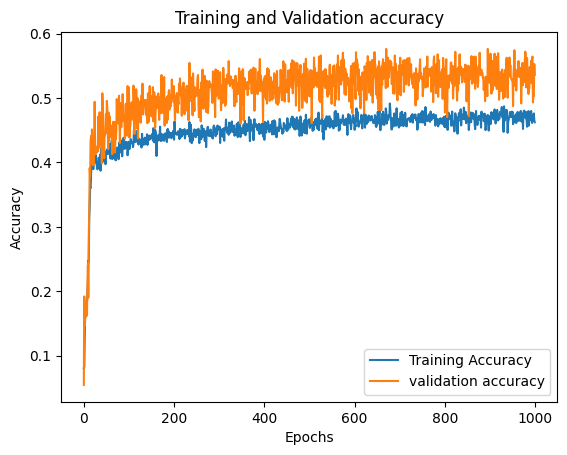

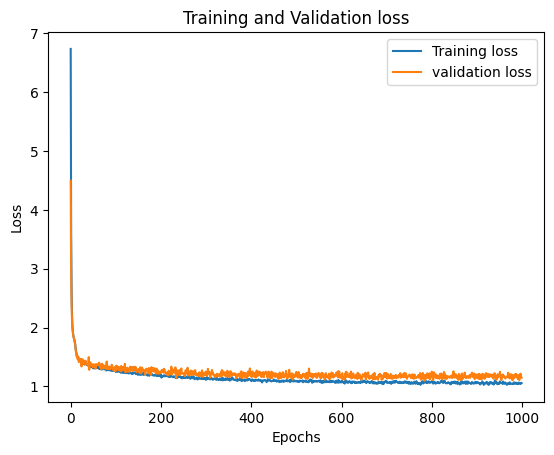

In [ ]:
plot_history(CNN_history)

To make predictions for the CNN model we reshape the yamnet embeddings to be 3 dimensional

In [ ]:
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
X_test_reshaped.shape

(3573, 41, 1024, 1)

#### Using the Yamnet_CNN model to make predictions on the test data

In [ ]:
CNN_y_pred = np.argmax(CNN_model.predict(X_test_reshaped), axis = -1)
CNN_y_pred

112/112 [==============================] - 11s 12ms/step


array([3, 4, 4, ..., 0, 0, 0])

#### Printing the classification report for the Yamnet_CNN model

In [ ]:
print(classification_report(y_test, CNN_y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.2915    0.8778    0.4377        90
           1     0.2618    0.6403    0.3716       139
           2     0.3881    0.4692    0.4248       569
           3     0.2972    0.5551    0.3871       508
           4     0.8166    0.3828    0.5213      1698
           5     0.9357    0.8699    0.9016       569

    accuracy                         0.5211      3573
   macro avg     0.4985    0.6325    0.5073      3573
weighted avg     0.6587    0.5211    0.5395      3573



#### Displaying the classification report for the Yamnet_CNN model

<Figure size 2000x3000 with 0 Axes>

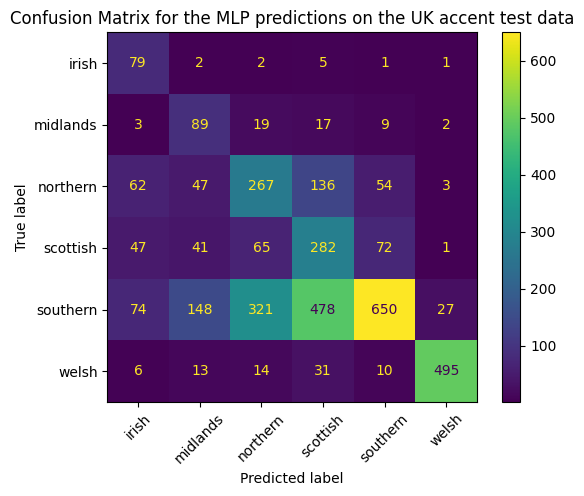

In [ ]:
class_names = ["irish", "midlands", "northern", "scottish", "southern", "welsh"]
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(y_test, CNN_y_pred, display_labels = class_names)
plt.xticks(rotation=45)
plt.title("Confusion Matrix for the MLP predictions on the UK accent test data")
plt.show()

Testing to see a single prediction for the yamnet_CNN model

In [ ]:
single_prediction("/content/drive/MyDrive/Accent Detection/Data/train/midlands/mif_02484_00326352632.wav", 3, CNN_model, "midlands")

1/1 [==============================] - 0s 143ms/step


{'Prediction': 'midlands',
 'confidence_levels':       class  Confidence level
 0     irish              0.05
 1  midlands             65.45
 2  northern              9.09
 3  scottish              8.35
 4  southern             15.25
 5     welsh              1.80,
 'play_audio': <pydub.audio_segment.AudioSegment at 0x78ac2b015ed0>}

## Building a LSTM to classify on the yamnet embeddings

#### Defining the architecture of the Yamnet_LSTM model

In [ ]:
tf.keras.backend.clear_session()
LSTM_model = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value=0., input_shape = (X_train.shape[1], X_train.shape[2])),

    tf.keras.layers.LSTM(256, return_sequences = True, kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.LSTM(256, return_sequences = True, kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.LSTM(128, kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),

    # Dense layer
    tf.keras.layers.Dense(128, activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(256, activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(64, activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    # Output layer
    tf.keras.layers.Dense(6, activation = "softmax")
])

#### Compiling the LSTM

In [ ]:
LSTM_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ["accuracy"]
              )

LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 41, 1024)          0         
                                                                 
 lstm (LSTM)                 (None, 41, 256)           1311744   
                                                                 
 dropout (Dropout)           (None, 41, 256)           0         
                                                                 
 batch_normalization (Batch  (None, 41, 256)           1024      
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 41, 256)           525312    
                                                                 
 dropout_1 (Dropout)         (None, 41, 256)           0         
                                                        

#### Training the model

In [ ]:
with tf.device('/GPU:0'):
  LSTM_history = LSTM_model.fit(X_train, tf.keras.utils.to_categorical(y_train),
                      validation_data = (X_val, tf.keras.utils.to_categorical(y_val)),
                      epochs = 1000,
                      batch_size = 256,
                      class_weight = class_weights)

Epoch 1/1000
45/45 [==============================] - 20s 153ms/step - loss: 3.6028 - accuracy: 0.5208 - val_loss: 3.8478 - val_accuracy: 0.5281
Epoch 2/1000
45/45 [==============================] - 2s 52ms/step - loss: 3.5611 - accuracy: 0.5195 - val_loss: 3.8779 - val_accuracy: 0.5180
Epoch 3/1000
45/45 [==============================] - 2s 51ms/step - loss: 3.5042 - accuracy: 0.5183 - val_loss: 3.7500 - val_accuracy: 0.5190
Epoch 4/1000
45/45 [==============================] - 2s 52ms/step - loss: 3.4793 - accuracy: 0.5234 - val_loss: 3.9051 - val_accuracy: 0.4876
Epoch 5/1000
45/45 [==============================] - 2s 52ms/step - loss: 3.4177 - accuracy: 0.5284 - val_loss: 3.8149 - val_accuracy: 0.4904
Epoch 6/1000
45/45 [==============================] - 2s 51ms/step - loss: 3.3963 - accuracy: 0.5332 - val_loss: 3.7849 - val_accuracy: 0.5044
Epoch 7/1000
45/45 [==============================] - 2s 52ms/step - loss: 3.3431 - accuracy: 0.5266 - val_loss: 3.8740 - val_accuracy: 0.49

In [ ]:
# save_to_pickle(pickle_prepared_model_path, "Yamnet_LSTM_55_2", [LSTM_model, LSTM_history])

In [ ]:
LSTM = read_pickle(pickle_prepared_model_path, "Yamnet_LSTM_55_final.pkl")
LSTM_model = LSTM[0]
LSTM_history = LSTM[1]

#### Plotting the training and validation loss and accuracy for the yamnet - LSTM model

+ The plot has this shape because it was trained in two phases with two different learning rates of  0.00001 and  0.00005 in order to achieve convergence

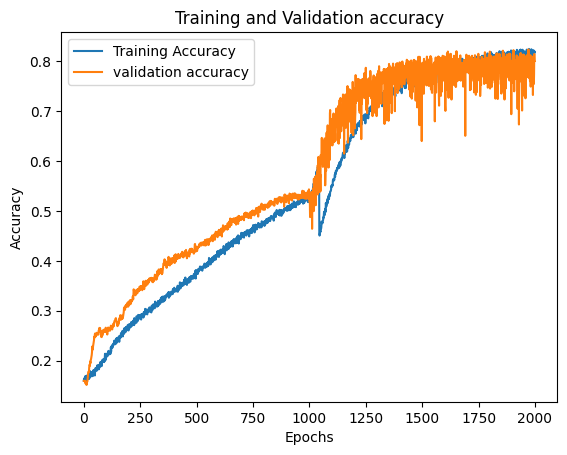

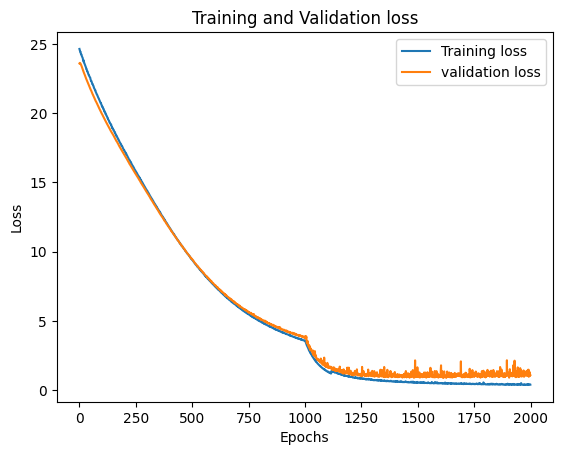

In [ ]:
plot_history(LSTM_history)

Making predictions with the Yamnet_LSTM model

In [ ]:
LSTM_y_pred = np.argmax(LSTM_model.predict(X_test), axis = -1)
LSTM_y_pred

112/112 [==============================] - 6s 9ms/step


array([4, 4, 4, ..., 0, 0, 0])

#### diplaying the classification report and the confusion matrix of the Yamnet - LSTM model

              precision    recall  f1-score   support

           0     0.8202    0.8111    0.8156        90
           1     0.6221    0.7698    0.6881       139
           2     0.6279    0.7592    0.6874       569
           3     0.6905    0.5886    0.6355       508
           4     0.8520    0.8104    0.8307      1698
           5     0.9514    0.9631    0.9572       569

    accuracy                         0.7935      3573
   macro avg     0.7607    0.7837    0.7691      3573
weighted avg     0.7994    0.7935    0.7943      3573



<Figure size 2000x3000 with 0 Axes>

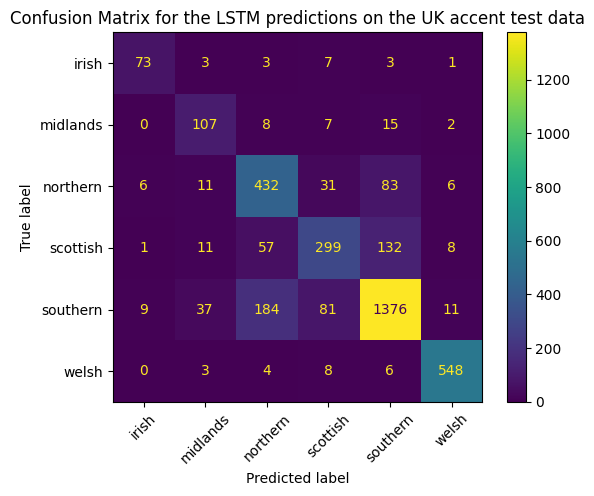

In [ ]:
display_classification_report(y_test, LSTM_y_pred, "LSTM", class_names)

#### Testing a single prediction for the yamnet - LSTM model

In [ ]:
single_prediction("/content/drive/MyDrive/Accent Detection/Data/train/midlands/mif_02484_00326352632.wav", 2, LSTM_model, "midlands")

1/1 [==============================] - 3s 3s/step


{'Prediction': 'midlands',
 'confidence_levels':       class  Confidence level
 0     irish               0.0
 1  midlands             100.0
 2  northern               0.0
 3  scottish               0.0
 4  southern               0.0
 5     welsh               0.0,
 'play_audio': <pydub.audio_segment.AudioSegment at 0x78acaa639150>}

## Building an MLP to classify the yamnet embeddings

#### Building the Yamnet_MLP architecture

+ We found that using dropouts and regularizers were effective in mitigating overfitting as seen below

In [ ]:
tf.keras.backend.clear_session()


MLP_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]), name="embedding"),

    tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5, name="dropout_1"),

    tf.keras.layers.Dense(384, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2, name="dropout_2"),

    tf.keras.layers.Dense(192, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.6, name="dropout_3"),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(384, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2, name="dropout_4"),
    tf.keras.layers.Dense(6, activation='softmax')

])

MLP_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 41, 256)           262400    
                                                                 
 dropout_1 (Dropout)         (None, 41, 256)           0         
                                                                 
 dense_1 (Dense)             (None, 41, 384)           98688     
                                                                 
 dropout_2 (Dropout)         (None, 41, 384)           0         
                                                                 
 dense_2 (Dense)             (None, 41, 192)           73920     
                                                                 
 dropout_3 (Dropout)         (None, 41, 192)           0         
                                                                 
 flatten (Flatten)           (None, 7872)              0

#### Compiling the MLP model

We compiled the Yamnet MLP models using a learning rate of  0.000005 on the ADAM Optimizer and a categorical cross entropy loss function

In [ ]:
MLP_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000005),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ["accuracy"]
              )

#### Training the MLP model

We trained the yamnet_MLP for 2000 epochs with a batch size of 256 for optimal convergence

In [ ]:
#tf.keras.backend.clear_session()
#lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
with tf.device('/GPU:0'):
  MLP_history = MLP_model.fit(
      X_train, keras.utils.to_categorical(y_train), batch_size = 256,
      epochs = 2000, verbose = 1,
      validation_data = (X_val, keras.utils.to_categorical(y_val)),
      class_weight = class_weights
  )

Epoch 1/2000
45/45 [==============================] - 9s 60ms/step - loss: 18.9213 - accuracy: 0.1227 - val_loss: 18.7340 - val_accuracy: 0.1342
Epoch 2/2000
45/45 [==============================] - 1s 30ms/step - loss: 18.7354 - accuracy: 0.1542 - val_loss: 18.5665 - val_accuracy: 0.1492
Epoch 3/2000
45/45 [==============================] - 1s 31ms/step - loss: 18.5652 - accuracy: 0.1630 - val_loss: 18.4132 - val_accuracy: 0.1615
Epoch 4/2000
45/45 [==============================] - 1s 30ms/step - loss: 18.4193 - accuracy: 0.1611 - val_loss: 18.2652 - val_accuracy: 0.1741
Epoch 5/2000
45/45 [==============================] - 1s 31ms/step - loss: 18.2689 - accuracy: 0.1641 - val_loss: 18.1206 - val_accuracy: 0.1800
Epoch 6/2000
45/45 [==============================] - 1s 31ms/step - loss: 18.1189 - accuracy: 0.1681 - val_loss: 17.9789 - val_accuracy: 0.1863
Epoch 7/2000
45/45 [==============================] - 1s 31ms/step - loss: 17.9605 - accuracy: 0.1722 - val_loss: 17.8373 - val_ac

#### Saving the YamNet_MLP model as a pickle object

In [ ]:
# save_to_pickle(pickle_prepared_model_path, "Yamnet_MLP", [MLP_model, MLP_history])

#### Reading the yamnet_MLP model back in

In [ ]:
MLP = read_pickle(pickle_prepared_model_path, "Yamnet_MLP.pkl")
MLP_model = MLP[0]
MLP_history = MLP[1]

plotting the training and validation accuracy and losses for the Yamnet_MLP model

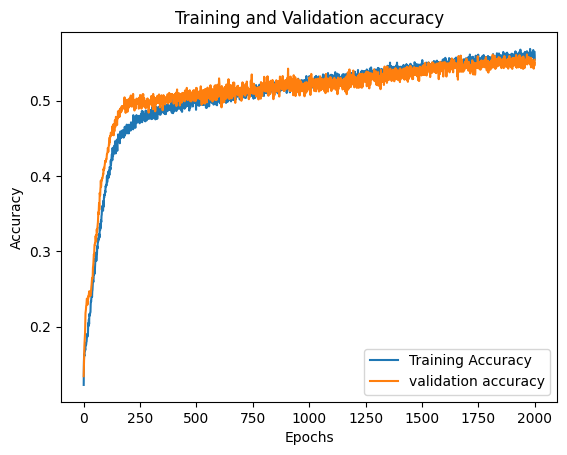

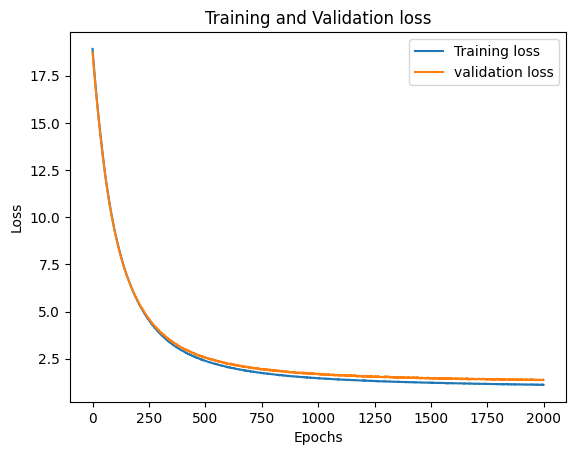

In [ ]:
plot_history(MLP_history)

Making predictions on the test data using the Yamnet_MLP model

In [ ]:
MLP_y_pred = np.argmax(MLP_model.predict(X_test), axis = -1)
MLP_y_pred

112/112 [==============================] - 1s 4ms/step


array([3, 4, 4, ..., 0, 0, 0])

#### Displaying the classification report and the confusion matrix for the yamnet MLP model

In [ ]:
MLP_y_pred = np.argmax(MLP_model.predict(np.concatenate((X_train, X_test))), axis = -1)


470/470 [==============================] - 2s 4ms/step


              precision    recall  f1-score   support

           0     0.4405    0.9497    0.6018       378
           1     0.4108    0.8547    0.5549       585
           2     0.3922    0.6244    0.4818      2391
           3     0.3612    0.4860    0.4144      2136
           4     0.7995    0.4451    0.5719      7133
           5     0.9451    0.9210    0.9329      2393

    accuracy                         0.5840     15016
   macro avg     0.5582    0.7135    0.5929     15016
weighted avg     0.6713    0.5840    0.5927     15016



<Figure size 2000x3000 with 0 Axes>

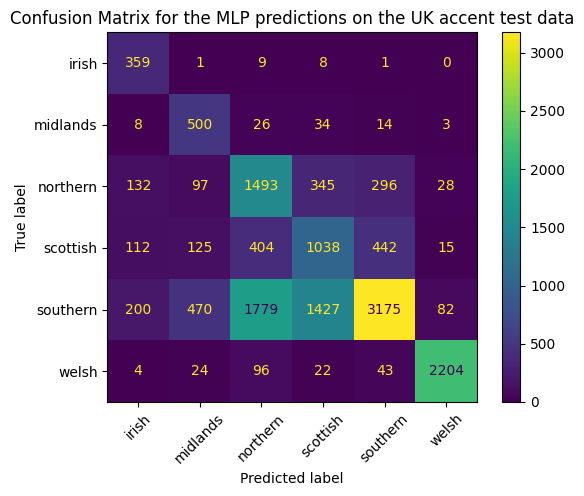

In [ ]:
display_classification_report(np.concatenate((y_train, y_test)), MLP_y_pred, "MLP", class_names)

This marks the end of this notebook